In [81]:
import pandas as pd
import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [94]:
data = pd.read_csv('../depression.csv', lineterminator='\n')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 957593 entries, 0 to 957592
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   title      957589 non-null  object
 1   self_text  851537 non-null  object
dtypes: object(2)
memory usage: 14.6+ MB


In [95]:
data.isnull().sum()

title             4
self_text    106056
dtype: int64

#### Remove all nans after being scraped from subreddit

In [96]:
data.replace(np.nan, '', regex=True, inplace = True)
data.isnull().sum()

title        0
self_text    0
dtype: int64

#### Append title and text together

In [14]:
data['title'] = data['title'].astype('str')
data['self_text'] = data['self_text'].astype('str')

#### Check if there is the regular check-in post

In [97]:
reminder_text = ["Regular Check-In Post", "Regular Check-In Post. Plus, a reminder about the No-Activism Rule."]
reminder_text = [i.lower() for i in reminder_text]
data['count_regular_check'] = data['title'].apply(lambda x: search_word(x.lower(), reminder_text))

In [98]:
data[data['count_regular_check']==1]

,title,self_text,count_regular_check
167043,I'm doing a regular check-in post for goal kee...,[removed],1
558691,Regular Check-In Post,Welcome to /r/depression's check-in post - a p...,1
654109,Regular Check-In Post,Welcome to /r/depression's check-in post - a p...,1
687307,"The fact the ""Regular Check-In Post"" was over ...",,1
742651,Regular Check-In Post,Welcome to /r/depression's check-in post - a p...,1
842974,Regular Check-In Post,Welcome to /r/depression's check-in post - a p...,1


In [99]:
len_post = data[data['count_regular_check']==1].shape[0]
print(f'There are {len_post} post of regular check-in')

There are 6 post of regular check-in


In [100]:
data = data.loc[data['count_regular_check']==0]

In [101]:
data.shape

(957587, 3)

#### Append the title and text together

In [102]:
data['texts'] = data['title']+" "+data['self_text']

In [103]:
data.drop(labels=['title', 'self_text'], axis=1, inplace = True)

In [104]:
data.head()

,count_regular_check,texts
0,0,So many kinds of therapists...what to choose? ...
1,0,i'm drawing a comic thing ---
2,0,Tired of rejection.. I'm 20 [M] and never had ...
3,0,Everyone thinks I'm fine.. but I'm no where cl...
4,0,honesty I drink most nights because I am unhap...


#### Find specific occurences of depressed words

In [105]:
words_of_interest = ['depressed', 'depression', 'stress', 'help', 
                     'suicide', 'devastated', 'frustrated',
                    "upsetting", "distressing", "painful", "heartbreaking", 
                     "dispiriting", "disheartening", "discouraging", "demoralizing"]

In [106]:
def search_word(data, words):
    for each_word in words:
        if re.search(each_word, data):
            return 1
    return 0

In [107]:
data['count'] = data['texts'].apply(lambda x: search_word(x, words_of_interest))

In [108]:
tot = data['count'].sum()
print(f'Number of posts that contain depressed words: {tot}')

Number of posts that contain depressed words: 514864


In [109]:
data[data['count']==0].head()

,count_regular_check,texts,count
1,0,i'm drawing a comic thing ---,0
2,0,Tired of rejection.. I'm 20 [M] and never had ...,0
4,0,honesty I drink most nights because I am unhap...,0
10,0,I hate taking medication I hate taking the med...,0
15,0,Wanna talk?,0


#### Find ambiguous posts

In [110]:
data['len_text'] = data['texts'].apply(lambda x: len(x.split()))

In [111]:
no_depressed_words = data[data['count']==0]

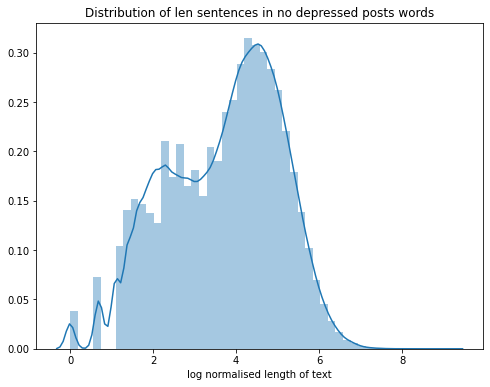

In [112]:
plt.figure(figsize=(8, 6))
sns.distplot(np.log(no_depressed_words['len_text']))
plt.title('Distribution of len sentences in no depressed posts words')
plt.xlabel('log normalised length of text')
plt.show()

In [115]:
no_depressed_words[no_depressed_words['len_text']<=8].head(20)

,count_regular_check,texts,count,len_text
1,0,i'm drawing a comic thing ---,0,6
15,0,Wanna talk?,0,2
36,0,Why? http://25.media.tumblr.com/tumblr_llseziv...,0,2
48,0,Self portrait. The links in my comments..,0,7
136,0,"Feeling a bit lonely, want to chat",0,7
166,0,"A ""creative outlet"" http://imgur.com/a/zVtaJ",0,4
174,0,Sadness can feel good too...,0,5
179,0,how i feel every day (xpost from r/funny),0,8
206,0,The power of controlling your own emotions..,0,7
300,0,I fucking hate my life ugh,0,6


It seems that sentences with length below 8 may be a bit ambiguous; thus, it is best to discard this sentences. Based on google, the average words for a proper sentences are 15.

In [116]:
remove_this_index = no_depressed_words[no_depressed_words['len_text']<15].index

In [117]:
retain_index = set(data.index)-set(remove_this_index)
data = data.loc[retain_index, :]

In [119]:
data.shape

(840632, 4)

## Tokenize and Clean

In [16]:
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/student.unimelb.edu.au/jprasetiyo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [15]:
data['tokenized_text'] = data['texts']

In [17]:
data['tokenized_text'] = data["tokenized_text"].apply(lambda x: x.lower()).apply(word_tokenize)

In [18]:
stop_words = [ 'what', 'which', 'who', 'whom', 'this', 'that', "that'll",'these', 'those', 'am', 'is', 'was', 'were',
 'be','been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but',
 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into',
 'through', 'during', 'before','after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on','off', 'over',
 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each',
 'few', 'more', 'most', 'other', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can',
 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't",
 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn',
  "isn't", 'ma', 'mightn',"mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
 "wasn't", 'weren', "weren't", 'won',"won't", 'wouldn',"wouldn't", "http"]


# remove stop words
data['tokenized_text'] = data["tokenized_text"].apply(lambda x: [word for word in x if word not in stop_words])

In [20]:
# remove non alphanumeric words
data['tokenized_text'] = data["tokenized_text"].apply(lambda x: [word for word in x if word.isalnum()])

In [21]:
data.to_pickle("depression_tokenized.pickle", index=False)

In [22]:
data

,texts,count,tokenized_text
0,So many kinds of therapists...what to choose? ...,1,"[many, kinds, therapists, choose, pretty, simp..."
1,i'm drawing a comic thing ---,0,"[i, drawing, comic, thing]"
2,Tired of rejection.. I'm 20 [M] and never had ...,0,"[tired, i, 20, never, real, girlfriend, relati..."
3,Everyone thinks I'm fine.. but I'm no where cl...,1,"[everyone, thinks, i, i, close, i, really, min..."
4,honesty I drink most nights because I am unhap...,0,"[honesty, i, drink, nights, i, unhappy, i, unh..."
...,...,...,...
957588,Someone please answer As you can see by the ti...,1,"[someone, please, answer, you, see, title, my,..."
957589,I've usually been the person to show up and he...,1,"[i, usually, person, show, help, everyone, i, ..."
957590,My life is just kinda shit I'm a college stude...,0,"[my, life, kinda, shit, i, college, student, i..."
957591,I survived A few months ago I survived an over...,0,"[i, survived, months, ago, i, survived, overdo..."


In [23]:
from nltk.stem import PorterStemmer
ps = PorterStemmer() 

data['tokenized_text'] = data["tokenized_text"].apply(lambda x: [ps.stem(word) for word in x])

In [25]:
data.to_pickle("depression_tokenised_stemmed.pickle", index = False)